In [1]:
# Necessary imports
import findspark
findspark.init() # Find Spark installation

from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType, StringType, BooleanType, TimestampType, StructType, StructField

# For ML tasks (even if demonstrating MapReduce concepts, preprocessing often uses MLlib)
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, Bucketizer
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector
from pyspark.mllib.linalg.distributed import IndexedRow, IndexedRowMatrix # For potential matrix operations

import math
import heapq
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

import sys
from pathlib import Path

sys.path.append(str(Path("../..").resolve()))

from src.data_ingestion import *
from src.data_preprocessing import *
from src.descriptive_analytics import *

from pyspark.sql import DataFrame
from pyspark.sql.functions import col
from pyspark.sql import functions as F

import seaborn as sns

import numpy as np

from itertools import combinations

from scipy import stats

import matplotlib.pyplot as plt

import pandas as pd
from pyspark.sql.window import Window

from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.linalg import Vectors




In [2]:
spark = init_spark()
df = load_data(spark, "../../data/US_Accidents_March23.csv")


In [3]:
from pyspark.sql.functions import hour, dayofweek, month, year, when

# Extract time-based features from Start_Time
df = df.withColumn("hour_of_day", hour(df["Start_Time"]))
df = df.withColumn("day_of_week", dayofweek(df["Start_Time"]))
df = df.withColumn("month", month(df["Start_Time"]))
df = df.withColumn("year", year(df["Start_Time"]))

# Handle categorical features - Weather_Condition
df = df.withColumn("weather_condition_cat", when(df["Weather_Condition"] == "Clear", 0)
                                            .when(df["Weather_Condition"] == "Rain", 1)
                                            .when(df["Weather_Condition"] == "Snow", 2)
                                            .otherwise(3))

# Add a binary feature for day/night based on the time of the accident
df = df.withColumn("is_night", when((df["hour_of_day"] >= 18) | (df["hour_of_day"] < 6), 1).otherwise(0))

# Create a boolean flag for severe accidents (Severity >= 3)
df = df.withColumn("severe_accident", when(df["Severity"] >= 3, 1).otherwise(0))

df.show(5)


+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-----------+-----+----+---------------------+--------+---------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visib

In [4]:
# Fill missing values in columns like temperature, wind speed with the mean or median
from pyspark.ml.feature import Imputer

imputer = Imputer(inputCols=["Temperature(F)", "Wind_Speed(mph)", "Humidity(%)"], outputCols=["Temperature_imputed", "Wind_Speed_imputed", "Humidity_imputed"])
df = imputer.fit(df).transform(df)

# Drop rows with missing target variables (if any)
df = df.dropna(subset=["Severity"])


In [5]:
# Split the data into training and testing sets (80% train, 20% test)
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)


In [6]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler

# Assemble features into a single vector column for logistic regression
logistic_features = ["hour_of_day", "day_of_week", "month", "Temperature_imputed", "Wind_Speed_imputed", "Humidity_imputed", "is_night", "weather_condition_cat"]
assembler = VectorAssembler(inputCols=logistic_features, outputCol="features")
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# Train a Logistic Regression model to predict severe accidents
lr_model = LogisticRegression(labelCol="severe_accident", featuresCol="features")
model = lr_model.fit(train_data)

# Make predictions on the test data
logistic_predictions = model.transform(test_data)

# Evaluate the model (Accuracy, Precision, Recall, F1-Score)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="severe_accident", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(logistic_predictions)
print(f"Logistic Regression Accuracy: {accuracy:.2f}")

# Optional: Evaluate Precision, Recall, and F1 Score
precision_evaluator = MulticlassClassificationEvaluator(labelCol="severe_accident", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="severe_accident", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="severe_accident", predictionCol="prediction", metricName="f1")

precision = precision_evaluator.evaluate(logistic_predictions)
recall = recall_evaluator.evaluate(logistic_predictions)
f1 = f1_evaluator.evaluate(logistic_predictions)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Logistic Regression Accuracy: 0.81
Precision: 0.73
Recall: 0.81
F1-Score: 0.72


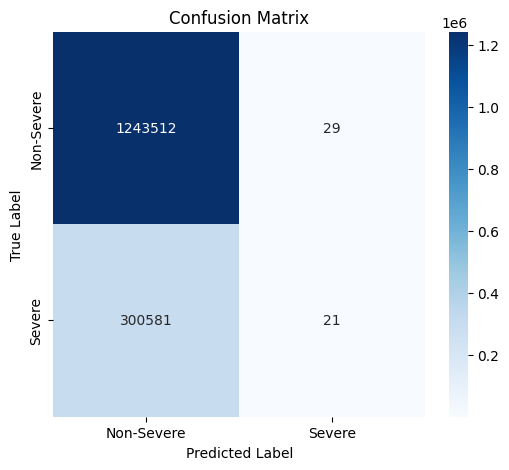

In [7]:
# Collecting the predictions and actual values for further analysis
predictions_df = logistic_predictions.select("severe_accident", "prediction").toPandas()

# Visualizing the Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create confusion matrix
conf_matrix = confusion_matrix(predictions_df["severe_accident"], predictions_df["prediction"])

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Severe", "Severe"], yticklabels=["Non-Severe", "Severe"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

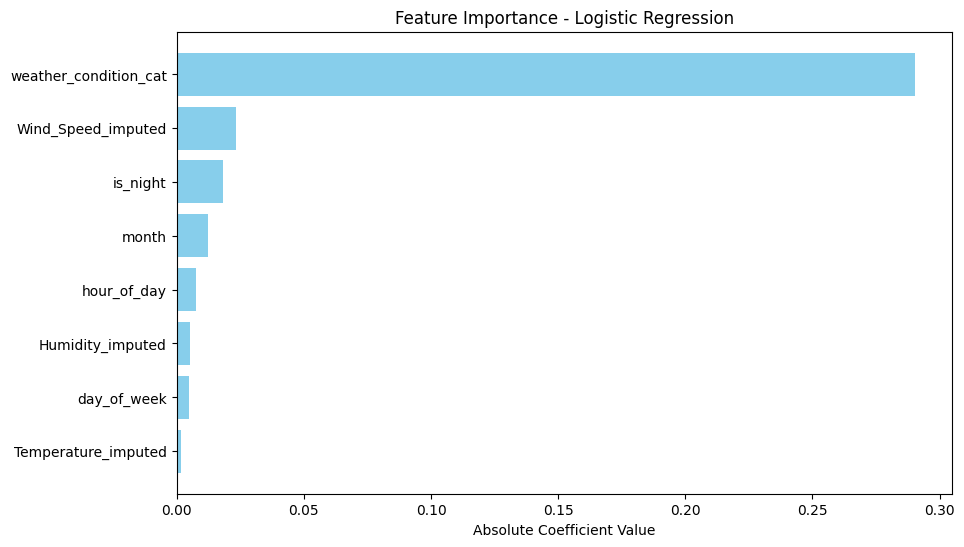

                 Feature  Coefficient
7  weather_condition_cat    -0.290270
4     Wind_Speed_imputed     0.023321
6               is_night     0.018237
2                  month    -0.012177
0            hour_of_day     0.007413
5       Humidity_imputed     0.005141
1            day_of_week    -0.004697
3    Temperature_imputed     0.001640


In [10]:
from pyspark.ml.classification import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt

coefficients = model.coefficients.toArray()
intercept = model.intercept
features = logistic_features

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

feature_importance_df['Abs_Coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Abs_Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance - Logistic Regression')
plt.gca().invert_yaxis()
plt.show()

print(feature_importance_df[['Feature', 'Coefficient']])

